In [ ]:
# TODO:
# - Tune hyperparameters
# - Reshape images before optimization
# - Use feature vectors
# - Optimize dlatent instead of zp

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount = True)

Mounted at /content/drive/


In [ ]:
# Create tempStyleGan2 folder in drive and put face image
%cd '/content/drive/My Drive/tempStyleGan2'

/content/drive/My Drive/tempStyleGan2


In [ ]:
!git clone https://github.com/rosasalberto/StyleGAN2-TensorFlow-2.x.git

fatal: destination path 'StyleGAN2-TensorFlow-2.x' already exists and is not an empty directory.


In [ ]:
%cd '/content/drive/My Drive/tempStyleGan2/StyleGAN2-TensorFlow-2.x'

/content/drive/My Drive/tempStyleGan2/StyleGAN2-TensorFlow-2.x


In [ ]:
# Imports
import sys
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from utils.utils_stylegan2 import convert_images_to_uint8

from stylegan2_generator import StyleGan2Generator

In [ ]:
# tf.compat.v1.disable_eager_execution()

In [ ]:
# Generator (turn gpu=False if using cpu)
generator = StyleGan2Generator(weights='ffhq', impl='ref', gpu=True)

Loaded ffhq generator weights!


In [ ]:
# Generate image
def generate(z):
    # running mapping network
    dlatents = generator.mapping_network(z)
    # running synthesis network
    out = generator.synthesis_network(dlatents)
    #converting image/s to uint8
    img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=False)
    return img

In [ ]:
%cd '/content/drive/My Drive/tempStyleGan2'

/content/drive/My Drive/tempStyleGan2


In [ ]:
# Latent vector (random starting point)
start_zp = np.random.normal(size=(1, 512))
zp = tf.Variable(start_zp, trainable=True, dtype=tf.float32)

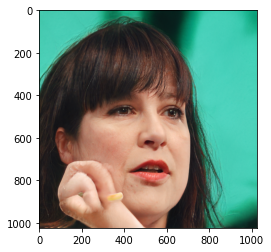

In [ ]:
# Save old zp and generate
pre_zp = zp
plt.imshow(generate(pre_zp).numpy()[0]/255)

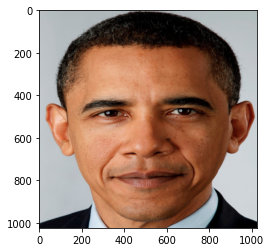

In [ ]:
from PIL import Image

# Load Image

# start_img = Image.open(*image name in tempStyleGan2*)
start_img = Image.open('obama2.jpg')
start_img = start_img.resize((1024, 1024), Image.ANTIALIAS)
start_img_np = np.array(start_img)
plt.imshow(start_img_np)
fz = tf.Variable(start_img_np, tf.float32)
fz = tf.expand_dims(fz, 0)
fz = tf.cast(fz, tf.float32)
# fzp = getFeatureVector(start_img_np, False)

In [ ]:
# Optimization

# PARAMETERS TO TUNE
# - lr_schedule (initial_learning_rate, decay_steps, decay_rate, staircase) https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay
# - SGD (learning_rate, momentum, nesterove) https://keras.io/api/optimizers/sgd/
# - Choose different optimizer maybe
# - (Possibly) Find a better cost function (current cost is Mean Squared Error)

# Learning rate exponential decay
initial_learning_rate = 0.3459
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.005,
    staircase=True)

# Gradient descent
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule, 
                              # nesterove=True
                              )

# Cost function
loss = lambda: tf.reduce_mean(tf.square(generate(zp) - fz))
losses = []

# Epochs

epochs = 100

for i in range(epochs):
  with tf.GradientTape() as tp:
    loss_val = loss()
  gradients = tp.gradient(loss_val, zp)
  opt.apply_gradients(zip([gradients], [zp]))
  losses.append(loss_val.numpy())
  print("Epoch: ", i, ", Loss: ", loss_val.numpy())
  # if abs(loss[len(loss)-100] - loss_val) <= 100:
  #   break

Epoch:  0 , Loss:  2501.714
Epoch:  1 , Loss:  5533.6953
Epoch:  2 , Loss:  3053.7637
Epoch:  3 , Loss:  3013.5957
Epoch:  4 , Loss:  3115.5322
Epoch:  5 , Loss:  3254.378
Epoch:  6 , Loss:  3244.1272
Epoch:  7 , Loss:  3197.76
Epoch:  8 , Loss:  3204.2627
Epoch:  9 , Loss:  3135.2878
Epoch:  10 , Loss:  3171.5693
Epoch:  11 , Loss:  3161.1965
Epoch:  12 , Loss:  3066.6387
Epoch:  13 , Loss:  2999.0872
Epoch:  14 , Loss:  3030.585
Epoch:  15 , Loss:  3060.5469
Epoch:  16 , Loss:  2995.9824
Epoch:  17 , Loss:  2945.2893
Epoch:  18 , Loss:  2908.4304
Epoch:  19 , Loss:  2888.8396
Epoch:  20 , Loss:  2872.9229
Epoch:  21 , Loss:  2843.0823
Epoch:  22 , Loss:  2830.3425
Epoch:  23 , Loss:  2808.7053
Epoch:  24 , Loss:  2783.5066
Epoch:  25 , Loss:  2798.303
Epoch:  26 , Loss:  2786.0085
Epoch:  27 , Loss:  2747.714
Epoch:  28 , Loss:  2743.4797
Epoch:  29 , Loss:  2735.9922
Epoch:  30 , Loss:  2735.1582
Epoch:  31 , Loss:  2713.6624
Epoch:  32 , Loss:  2697.9995
Epoch:  33 , Loss:  2708.16

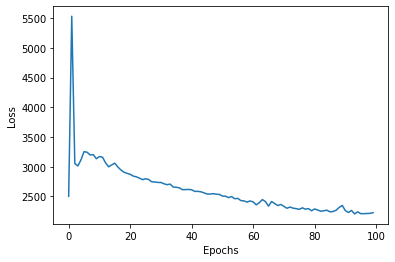

In [ ]:
# Show loss
plt.plot(np.arange(0, epochs, 1), losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.show()

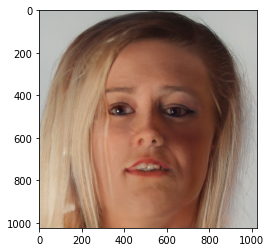

In [ ]:
# Generate image
plt.imshow(generate(zp).numpy()[0]/255)

In [ ]:
vector_folder = "obama/obamavectors/"
zp_val = zp.numpy()
np.save(vector_folder + "zp_rec", zp)

# Previous attempts

In [ ]:
# generated_image_folder = "obama/obamafolder"
# img = generate(zp).numpy()[0]/255
# Image.fromarray(img).save(generated_image_folder + "obamaGeneratedStyleGAN")

TypeError: ignored

In [ ]:
# Old stuff


# Decayed gradient descent
# global_step = tf.Variable(0, trainable=False)
# starter_learning_rate = 0.99
# learning_rate = tf.train.exponential_decay(starter_learning_rate,
                                          #  global_step,
                                          #  10000, 0.005)
# learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    # starter_learning_rate, decay_steps=10000, decay_rate=0.005)
# loss = lambda: tf.reduce_mean(tf.square(generate(zp) - fz))

# opt = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)

# # Optimize zp
# train = opt.minimize(loss, var_list=zp, tape=tf.GradientTape())

# sess = tf.Session()
# sess.run(tf.global_variables_initializer())
# for i in range(5):
#   _, loss_value, zp_val, eta = sess.run((train, mse, zp, 0.01))
#   # z_loss = np.sqrt(np.sum(np.square(zp_val - start_zp))/len(zp_val[0]))
#   print("%03d) eta=%03f, loss = %f" % (i, eta, loss_value))


In [ ]:
# # Optimization

# # PARAMETERS TO TUNE
# # - lr_schedule (initial_learning_rate, decay_steps, decay_rate, staircase) https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay
# # - SGD (learning_rate, momentum, nesterove) https://keras.io/api/optimizers/sgd/
# # - Choose different optimizer maybe
# # - (Possibly) Find a better cost function (current cost is Mean Squared Error)

# # Learning rate exponential decay
# initial_learning_rate = 0.99
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=10000,
#     decay_rate=0.005,
#     staircase=True)

# # Gradient descent
# opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule, #learning_rate = lr_schedule 
#                               momentum=0.9, 
#                               # nesterove=True
#                               )

# # Cost function
# loss = lambda: tf.reduce_mean(tf.square(getFeatureVector(generate(zp).numpy()) - fzp))
# losses = []

# # Epochs

# epochs = 200

# for i in range(epochs):
#   with tf.GradientTape() as tp:
#     loss_val = loss()
#   gradients = tp.gradient(loss_val, zp)
#   opt.apply_gradients(zip([gradients], [zp]))
#   losses.append(loss_val.numpy())
#   print("Epoch: ", i, ", Loss: ", loss_val.numpy())
#   # if abs(loss[len(loss)-100] - loss_val) <= 100:
#   #   break

LookupError: ignored

In [ ]:
# import keras

# # for loading/processing the images  
# from keras.preprocessing.image import load_img 
# from keras.preprocessing.image import img_to_array 
# from keras.applications.vgg16 import preprocess_input 
# from keras.applications.vgg16 import decode_predictions 
# from PIL import Image

# # models 
# from keras.applications.vgg16 import VGG16 
# from keras.models import Model

# # os, numpy, pandas
# import os
# import numpy as np
# import pandas as pd


# def getFeatureVector(img, generated=True):
#   if generated:
#     data = Image.fromarray((img[0] * 255).astype(np.uint8))
#   else:
#     data = Image.fromarray((img).astype(np.uint8))
#   data_reshaped = data.resize((224, 224), Image.ANTIALIAS)
#   img = np.array(data_reshaped)
#   model = VGG16()
#   model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
#   reshaped_img = img.reshape(1,224,224,3)
#   imgx = preprocess_input(reshaped_img)
#   feat = model.predict(imgx, use_multiprocessing=True)
#   return tf.Variable(feat, tf.float32)